In [107]:
import numpy as np
import scipy
import matplotlib.pyplot as plt 
from numpy.linalg import eig
import matplotlib.animation as animation
from IPython.display import clear_output

# General Parameters
mass_electron = 9.109534e-31 # 1.0 # [kg]
hbar = 6.582119569e-16 # [eV s] source: wikipedia
# length = 100.0 # [??]
number_steps = 500
electric_field = 0.0# 5 #0.01 # Electric field [V/nm]
electron_charge = 1 # 1.60217663e-19 # [C]
h_c = 1240 # eV nm

In [43]:
# plotting
PLOT_LIMIT = []#400,800]
Y_LIMIT = [] # leave blank for auto
ERROR_BARS = False
PLOT_FITTED = False
split_ = ","
LABEL_FONT_SIZE = 13
TICK_FONT_SIZE = 11
LINE_WIDTH = 0.5
LEGEND = True
label_x = ""
label_y = ""
plot_title = ""
aspect_ratio = [7,7]

colours = [ 'black','dimgrey','lightslategrey' ,'silver', 'cadetblue', 'teal','darkolivegreen','green','turquoise', 'olivedrab','seagreen']

def plot_graph(x, y): #create a single plot
    labels = []
    plt.figure()
    plt.rcParams["figure.figsize"] = (aspect_ratio[0],aspect_ratio[1])
    fig, ax = plt.subplots()
    plt.title(f"")
    #plt.xlabel(label_x, fontsize=LABEL_FONT_SIZE)
    #plt.ylabel(label_y,  fontsize=LABEL_FONT_SIZE)
    plt.xticks(fontsize = TICK_FONT_SIZE)
    plt.yticks(fontsize = TICK_FONT_SIZE)
    if(bool(Y_LIMIT) == True):
        plt.ylim(Y_LIMIT)
    if(bool(PLOT_LIMIT) == True):
        plt.xlim(PLOT_LIMIT)
    
    right_side = ax.spines["right"]
    top_side = ax.spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)
    plt.plot(x, y, linewidth = LINE_WIDTH, color = 'dimgrey', marker = 's', markersize = 0.5, markerfacecolor='dimgrey')
    plt.grid(True, alpha=0.2)
    #labels = np.array(labels)
    #plt.savefig(f'{file}_figure.png', dpi = 1000, bbox_inches='tight')
    plt.show()

def plot_graphs(x, y): #create a single plot
    labels = []
    plt.figure()
    plt.rcParams["figure.figsize"] = (6,6)
    fig, ax = plt.subplots()
    plt.title(plot_title)
    plt.xlabel(label_x, fontsize=LABEL_FONT_SIZE)
    plt.ylabel(label_y,  fontsize=LABEL_FONT_SIZE)
    #ax.xaxis.set_minor_locator(AutoMinorLocator())
    #plt.xticks(fontsize = TICK_FONT_SIZE)
    #plt.yticks(fontsize = TICK_FONT_SIZE)
    if(bool(Y_LIMIT) == True):
        plt.ylim(Y_LIMIT)
    if(bool(PLOT_LIMIT) == True):
        plt.xlim(PLOT_LIMIT)
    
    right_side = ax.spines["right"]
    top_side = ax.spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)
    i=0
    for ys in y:
        if i < len(colours):
            plt.plot(x, ys, linewidth = LINE_WIDTH, marker = 's', markersize = 0.5, color = colours[i])
        else:
            plt.plot(x, ys, linewidth = LINE_WIDTH, marker = 's', markersize = 0.5)
        i+=1
    plt.grid(True, alpha=0.2)
    if(LEGEND==True):
        plt.legend(legend)
    #labels = np.array(labels)
    #plt.savefig(f'{file}_figure.png', dpi = 1000, bbox_inches='tight')
    plt.show()

def make_array(y):
    p = np.zeros(number_steps)
    for nr in range(0, number_steps):
        p[nr] = y
    return p

In [32]:
# MATERIALS AND HETEROSTRUCTURE CLASSES
class Material:
    def __init__(self, electron_affinity, band_gap, e_eff_mass, lh_eff_mass, hh_eff_mass):
        self.electron_affinity = electron_affinity
        self.band_gap = band_gap
        self.e_eff_mass = e_eff_mass
        self.lh_eff_mass = lh_eff_mass
        self.hh_eff_mass = hh_eff_mass

def CBO(material1, material2): # Conduction Band Offset [eV] between 2 materials
    return (material1.electron_affinity - material2.electron_affinity)

def VBO(material1, material2): # Valence Band Offset [eV] between 2 materials
    calc1 = material1.electron_affinity + material1.band_gap
    calc2 = material2.electron_affinity + material2.band_gap
    return (calc2 - calc1)

class Layer:
    def __init__(self, material, thickness): # thickness in [nm]
        self.material = material
        self.thickness = thickness
        
class Heterostructure: 
    layers = np.empty(0, dtype=Layer)
    conduction_potential = np.empty(0, dtype=float)
    valence_potential = np.empty(0, dtype=float)
    heterostructure_thickness = 0.0
    
    def __init__(self, layers): # thickness in [nm]
        self.layers = layers
        self.conduction_potential = np.array(0)
        self.valence_potential = np.array(0)
        total_thickness = 0
        for layer in self.layers:
            total_thickness += layer.thickness
        self.heterostructure_thickness = total_thickness
        #self.set_potentials()

    def add_layer(self, layer):
        self.layers.append(layer)
        #set_potentials()
        
    def clear_layers(self):
        self.layers.clear()
                
    def potential(self, particle, x): # potential as a function of x inside the structure (specific band energy)
        material_threshold = 0.0
        U = 0.0
        V = 0.0
        i = 0
        
        for layer in self.layers:
            material_threshold += layer.thickness
            if x >= material_threshold:
                if(over_ride_offsets == False):
                    U += CBO(self.layers[i].material, self.layers[i+1].material)
                    V += VBO(self.layers[i].material, self.layers[i+1].material)
                elif(over_ride_offsets == True):
                    U += CBO_override[i]
                    V += VBO_override[i]
                i = i + 1
            else: # if used correctly, there should never be an error here (one might occur when an x input is out of analysis bounds)
                if particle == 1 or particle == 2: # if particle is hole
                    return V - electron_charge*electric_field*(x-self.heterostructure_thickness) # not as efficient as defining a strict function globally but gives ALOT of freedom (only adds +(number of layers)*3 computations at most  
                elif particle == 0:                # else it is electron
                    return U + electron_charge*electric_field*x
                
    def eff_mass(self, particle, x): # get effective mass for material at x in semiconductor wafer
        material_threshold = 0.0
        for layer in self.layers:
            material_threshold += layer.thickness
            if x <= material_threshold:
                if particle == 'hh':
                    return layer.material.hh_eff_mass
                if particle == 'lh':
                    return layer.material.lh_eff_mass
                if particle == 'e':
                    return layer.material.e_eff_mass

In [33]:
# Example Materials // BG = Bandgap, EF = Electron Affinity @ 300K
BG_GaAs = 1.424 # [eV]
EF_GaAs = 4.07 # [eV] @ 300K !
x_ratio = 0.3
EF_AlGaAs = 4.07 - 1.1*x_ratio # [eV] (x<0.45) @ 300K !
BG_AlGaAs = 1.424 + 1.247*x_ratio # [eV] (x<0.45)

# Decleration: Material(EF, BG, e_eff_mass, lh_eff_mass, hh_eff_mass) @ 300K
GaAs = Material(EF_GaAs, BG_GaAs, 0.063*mass_electron, 0.082*mass_electron, 0.51*mass_electron)
AlGaAs = Material(EF_AlGaAs, BG_AlGaAs, (0.063+x_ratio*0.083)*mass_electron, (0.082+x_ratio*0.068)*mass_electron, (0.51+x_ratio*0.25)*mass_electron)
Free_Space = Material(0.0, 0.0, mass_electron, mass_electron, mass_electron)
GaInAs = Material(4.5, (0.36+0.63*x_ratio+0.43*x_ratio**2), 0.041*mass_electron, 0.052*mass_electron, 0.45*mass_electron)
InP = Material(4.38, 1.344, 0.08*mass_electron, 0.089*mass_electron, 0.6*mass_electron)

In [34]:
def solve(heterostructure): # Arbitrary, one operation, get all possible states/wavefunctions for a given structure
    Energies = np.zeros((3,number_steps))
    #eigenVector_ = [[0]*number_steps]*3
    eigenVector_ = [[0]*number_steps for _ in range(3)]

    for p in range(0, 3): # solve for electron, heavy hole, and light hole
        M = np.zeros((number_steps, number_steps))
        x = np.zeros(number_steps)

        delta_x = heterostructure.heterostructure_thickness / (number_steps + 1.0)
        x[0] = delta_x

        alpha_w = np.zeros(number_steps)
        alpha_e = np.zeros(number_steps)
        alpha_x = np.zeros(number_steps)

        particle = ['e', 'lh', 'hh']

        alpha_w[0] = -(hbar*hbar/2.0) * 1.0/(delta_x*delta_x) * 2.0/(heterostructure.eff_mass(particle[p],x[0])+heterostructure.eff_mass(particle[p],x[0]))
        alpha_e[0] = -(hbar*hbar/2.0) * 1.0/(delta_x*delta_x) * 2.0/(heterostructure.eff_mass(particle[p],x[0])+heterostructure.eff_mass(particle[p],x[1]))
        alpha_x[0] = -alpha_w[0]-alpha_e[0]

        M[0][0] = alpha_x[0] + heterostructure.potential(p,x[0])
        M[0][1] = alpha_e[0]

        for nr in range(0, number_steps):
            x[nr] = x[0] + nr*delta_x

        for nr in range(1, number_steps-1): #range runs from 1 to num_steps-2 (stupid)
            alpha_w[nr] = -(hbar*hbar/2.0) * 1.0/(delta_x*delta_x) * 2.0/(heterostructure.eff_mass(particle[p],x[nr])+heterostructure.eff_mass(particle[p],x[nr-1]))
            alpha_e[nr] = -(hbar*hbar/2.0) * 1.0/(delta_x*delta_x) * 2.0/(heterostructure.eff_mass(particle[p],x[nr])+heterostructure.eff_mass(particle[p],x[nr+1]))
            alpha_x[nr] = -alpha_w[nr]-alpha_e[nr]

            M[nr][nr-1] = alpha_w[nr]    #sub-diagonal
            M[nr][nr] = alpha_x[nr] + heterostructure.potential(p,x[nr]) #diagonal
            M[nr][nr+1] = alpha_e[nr]   #upper diagonal 

        alpha_w[number_steps-1] = -(hbar*hbar/2.0) * 1.0/(delta_x*delta_x) * 2.0/(heterostructure.eff_mass(particle[p],x[number_steps-1])+heterostructure.eff_mass(particle[p],x[number_steps-1-1]))
        alpha_e[number_steps-1] = -(hbar*hbar/2.0) * 1.0/(delta_x*delta_x) * 2.0/(heterostructure.eff_mass(particle[p],x[number_steps-1])+heterostructure.eff_mass(particle[p],x[number_steps-1])) # assuming m(x_edge-dx) = m(x_edge) as boundary condition
        alpha_x[number_steps-1] = -alpha_w[number_steps-1]-alpha_e[number_steps-1]
        M[number_steps-1][number_steps-2] = alpha_w[number_steps-1]
        M[number_steps-1][number_steps-1] = alpha_x[number_steps-1] + heterostructure.potential(p,x[number_steps-1])

        w,v=eig(M)

        idx = np.argsort(w) # sort in terms of energies
        w = w[idx]
        v = v[:,idx]
        
        for i in range(number_steps):
            #print(len(eigenVectors[0]))
            Energies[p][i] = w[i]
            eigenVector_[p][i] = v[:,i]
        
    return x, Energies, eigenVector_

def relative_energy(energy, p): # accept a 2 paramters [energy relative to well of..][particle type]
    # corrects an (inital) calculated energy from QW solution for respective band of type particle type p
    EF_offset = electron_charge*electric_field*QW.heterostructure_thickness
    BG = min(abs(layers[i].material.band_gap) for i in range (0, len(layers)-1)) # this should be okay with and without override on    
    if(p==0):
        if over_ride_offsets == True:
            E_REL = energy + BG + max(abs(CBO_override[i]) for i in range(0, len(layers)-1))
        else:
            E_REL = energy + BG + max(abs(CBO(layers[i].material, layers[i+1].material)) for i in range(0, len(layers)-1))
    else: #(p==1 or p==2):
        if over_ride_offsets == True:
            E_REL = -max(abs(VBO_override[i]) for i in range(0, len(layers)-1)) - energy + EF_offset
        else:
            E_REL = -max(abs(VBO(layers[i].material, layers[i+1].material)) for i in range(0, len(layers)-1)) - energy + EF_offset
    return E_REL

def find_transitions(energies): # accept a SORTED 2 Dimensional matrix [3][number_solutions] ... 
    E_gap = np.zeros((number_steps, number_steps, 2))
    for k in range(2): # for 2 hole types
        for i in range(len(energies[0])): # for all electrons
            for j in range(len(energies[0])): # and all hole states
                E_gap[i][j][k] = abs(energies[0][i]-energies[k+1][j])
    return E_gap # a matrix/array of energy transtions indexed as [electron state][hole state][hole type] 

def find_energies_relative(energies): # accept a 2 Dimensional matrix [3][number_solutions]
    energies_relative = np.zeros((3, number_steps))
    for k in range(3): # for 3 particle types
        for i in range(len(energies[0])): # for all states
            energies_relative[k][i] = relative_energy(energies[k][i], k)
    return energies_relative # returns [3][number_solutions] matrix of energies relative to their ectual value in well structure

def overlap_integral(vector1, vector2):    # S = <v_1|v_2> | accept only vectors of same length
    overlap = np.zeros(len(vector1))       # assuming both are the same length
    N1 = sum(abs(vector1)**2)              # Normalisation constant N = <v|v>
    N2 = sum(abs(vector2)**2)
    #print("N1 = {}".format(N1))
    #print("N2 = {}".format(N2))
    vector1_dummy = vector1 / N1           # normalise wavefunctions (N^-1)|v>
    vector2_dummy = vector2 / N2
    for i in range(len(vector1)):
        overlap[i] = (vector1_dummy[i]*vector2_dummy[i]) 
    return overlap                         # I = <v_1|v_2>

def I_squared(vector1, vector2):           # S = <v_1|v_2> | accept only vectors of same length
    overlap = overlap_integral(vector1, vector2)
    I_squared = sum(abs(overlap))**2
    return I_squared            # I^2 = |<v_1|v_2>|^2

def find_overlaps_all(wavefunctions): # accept matrix of size [particle type (0,1,2)][number_steps] directly from solve(QW)
    I_squared_matrix = np.zeros((number_steps, number_steps, 2)) # [electron state][hole state][hole type]
    for k in range(2): # for 2 hole types
        for i in range(len(wavefunctions[0])): # for all electrons
            state1 = wavefunctions[0][i]
            for j in range(len(wavefunctions[0])): # and all hole states
                state2 = wavefunctions[1+k][j] # [1+k] so that we index correct state - wavefunctions indexed as [particle type (0,1,2)][number_steps]
                I_squared_matrix[i][j][k] = I_squared(state1, state2)
    return I_squared_matrix # a matrix/array of wavefunction overlaps indexed as [electron state][hole state][hole type]

def convert_to_wavelength(E_GAP): # Gap between [electron state] and [hole state] of [hole type]
    E_GAP_WL = np.zeros((number_steps, number_steps, 2))
    for k in range(2): # for 2 hole types
        for i in range(number_steps): # for all electrons
            for j in range(number_steps): # and all hole states
                E_GAP_WL[i][j][k] = h_c / E_GAP[i][j][k]
    return E_GAP_WL
    
    

In [35]:
# DEFINE STRUCTURE ---------------------------------------------------------------------------
layer1 = Layer(AlGaAs, 10) # 10nm thick layer of GaAs
layer2 = Layer(GaAs, 10) # 10nm thick layer of AlGaAs
layers = [layer1, layer2, layer1]
QW = Heterostructure(layers)

# OVERRIDE BAND OFFSETS | Done by hand : Array lengths must be num.layers-1 ------------------
electric_field = 0.01
over_ride_offsets = True
E_gap_diff = np.abs(-layer2.material.band_gap + layer1.material.band_gap)
conduction_band_offset_ratio = 0.6
valence_band_offset_ratio = 0.4
print(E_gap_diff)

# VBO_override = [-layer2.material.band_gap*valence_band_offset_ratio, layer2.material.band_gap*valence_band_offset_ratio]
# CBO_override = [-layer2.material.band_gap*conduction_band_offset_ratio, layer2.material.band_gap*conduction_band_offset_ratio]

VBO_override = [-E_gap_diff*valence_band_offset_ratio, E_gap_diff*valence_band_offset_ratio]
CBO_override = [-E_gap_diff*conduction_band_offset_ratio, E_gap_diff*conduction_band_offset_ratio]
print(VBO_override)
print(CBO_override)
# SOLVE --------------------------------------------------------------------------------------
x, energies, wavefunctions = solve(QW) # returns 2D matrices, index [particle type][solution in order from lowest]

0.3741000000000001
[-0.14964000000000005, 0.14964000000000005]
[-0.22446000000000005, 0.22446000000000005]


<Figure size 600x600 with 0 Axes>

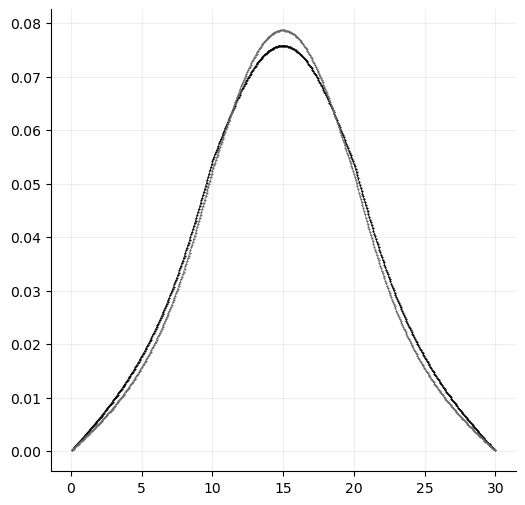

In [105]:
# RESULTS ------------------------------------------------------------------------------------
relative_energies = find_energies_relative(energies)
E_GAP = find_transitions(relative_energies)
plot_graphs(x, [wavefunctions[0][0], wavefunctions[1][0]])

In [109]:
E_GAP_WL = convert_to_wavelength(E_GAP)

In [257]:
# For each pair the overlap integral of the wavefunction should be calculated.
# This provides the strength of the oscillator, or the absorption.

# This operation takes time.

M_I_squared = find_overlaps_all(wavefunctions)

In [339]:
M_I_squared[0][0][0] # [electron state][hole state][hole type]

1.0000000000000004

<Figure size 600x600 with 0 Axes>

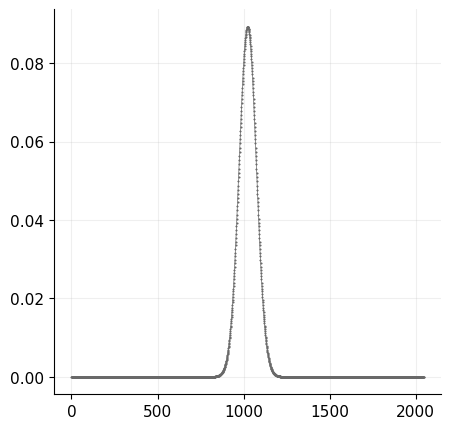

<Figure size 500x500 with 0 Axes>

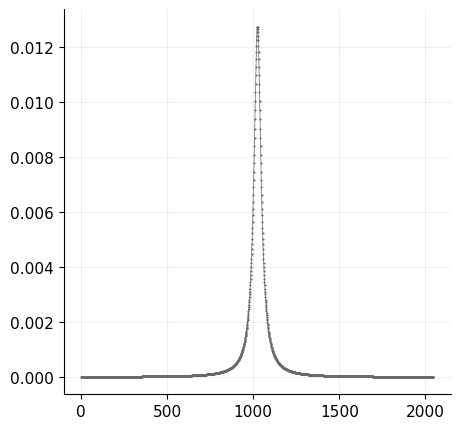

<Figure size 500x500 with 0 Axes>

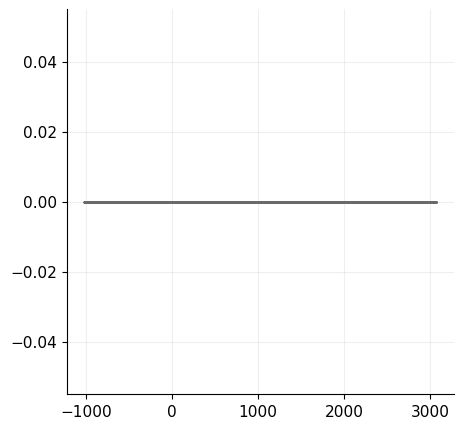

<Figure size 500x500 with 0 Axes>

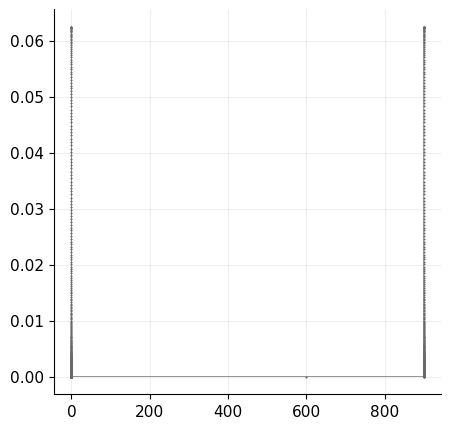

<Figure size 500x500 with 0 Axes>

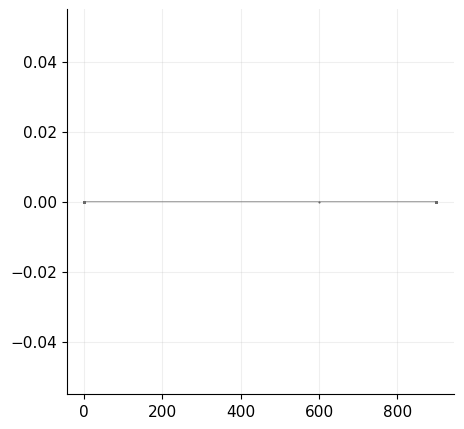

4096


In [110]:
# voigt function details
num_discrete = 2048
func_x = np.zeros(num_discrete)
Gauss_y = np.zeros(num_discrete)
Lorentz_y = np.zeros(num_discrete)
x_0 = num_discrete/2
gamma = 50
sigma = gamma
PLOT_LIMIT=[]

def pad_func_zeros(func):
    func_new = np.zeros(2*len(func))
    j = 0
    for i in range(int(0.25*len(func_new)), int(0.75*len(func_new))):
        func_new[i] = func[j]
        j+=1
    return func_new # twice in length

def pad_func_linear(func):
    func_new = np.zeros(2*len(func))
    j = 0
    del_f = np.abs(func[1]-func[2])
    for i in range(0, int(0.25*len(func_new))):
        func_new[i] = func[0]-0.5*(func[len(func)-1]-func[0]) + i*del_f
    for i in range(int(0.25*len(func_new)), int(0.75*len(func_new))):
        func_new[i] = func[j]
        j+=1
    w=j-1
    j=1
    for i in range(int(0.75*len(func_new)), len(func_new)):
        func_new[i] = func[w] + j*del_f
        j+=1
    return func_new # twice in length

def pad_E(f):
    del_f = np.max(f)/(num_discrete-1)
    func_new = np.zeros(2*len(f))
    j = 0
    for i in range(len(func_new)):
        func_new[i] = del_f*i
    return func_new # twice in length

def convolve(f, g): # PAD ARRAYS BEFORE USE FRO ABSORPTION
    FFT_f = np.fft.fft(f)
    FFT_g = np.fft.fft(g)
    FG = FFT_f * FFT_g
    result = np.fft.ifft(FG)
    return np.real(result)

for i in range(num_discrete):
    func_x[i] = i
    Gauss_y[i] = 1.0/np.sqrt(np.sqrt(2*np.pi)*sigma)*np.exp(-(func_x[i]-x_0)*(func_x[i]-x_0)/(2.0*sigma*sigma))
    Lorentz_y[i] = 1.0/np.pi * 0.5*gamma/((func_x[i]-x_0)**2 + (0.5*gamma)**2)

plot_graph(func_x,Gauss_y)
plot_graph(func_x,Lorentz_y)

func_x_new = pad_func_linear(func_x)
WL_axis_new = pad_func_linear(WL_xaxis)
absorption_yaxis_new = pad_func_zeros(absorption_yaxis)
Lorentz_y_new = pad_func_zeros(Lorentz_y)
#plot_graph(func_x_new, E_axis_new)
Gauss_y_new = pad_func_zeros(Gauss_y) 
plot_graph(func_x_new, absorption_yaxis_new)

voigt_y = convolve(Lorentz_y_new, Gauss_y_new)
plot_graph(WL_axis_new, voigt_y)
absorption = convolve(absorption_yaxis_new, voigt_y)
plot_graph(WL_axis_new, absorption)
print(len(voigt_y))


Bandgap: 1.4758314959285852 eV


<Figure size 600x600 with 0 Axes>

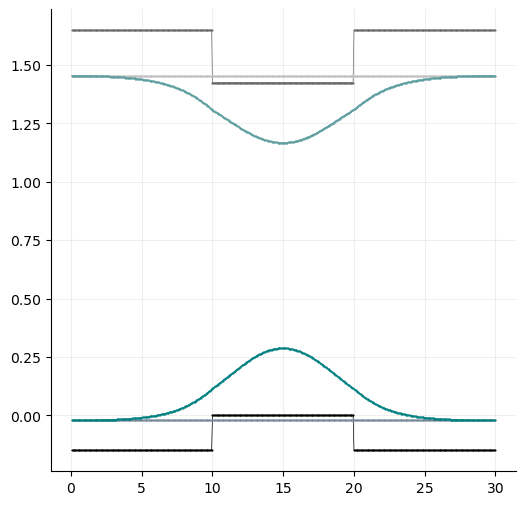

In [104]:
# LOGIC AND DATA TRANSFORMS FOR PLOTTING ENERGY DIAGRAMS

vector_scale = 50

electric_field = 0

pot_h = np.zeros(number_steps)
for nr in range(0, number_steps):
    pot_h[nr] = QW.potential(1, x[nr])
    
pot_e = np.zeros(number_steps)
for nr in range(0, number_steps):
    pot_e[nr] = QW.potential(0, x[nr])
    
EF_offset = electron_charge*electric_field*QW.heterostructure_thickness
BG = min(abs(layers[i].material.band_gap) for i in range (0, len(layers)-1))

E_1_REL = energies[0][0]+BG+max(abs(CBO(layers[i].material, layers[i+1].material)) for i in range(0, len(layers)-1))
E_2_REL = -max(abs(VBO(layers[i].material, layers[i+1].material)) for i in range(0, len(layers)-1)) - energies[1][0] + EF_offset

if over_ride_offsets == True:
    E_1_REL = energies[0][0]+BG+max(abs(VBO_override[i]) for i in range(0, len(layers)-1))
    E_2_REL = -max(abs(VBO_override[i]) for i in range(0, len(layers)-1)) - energies[1][0] + EF_offset
    
Bandgap = E_1_REL - E_2_REL
print("Bandgap: " + str(Bandgap) + " eV") # [eV]

b1 = -pot_h - max(abs(VBO(layers[i].material, layers[i+1].material)) for i in range(0, len(layers)-1)) + EF_offset
b2 = BG + pot_e + max(abs(CBO(layers[i].material, layers[i+1].material)) for i in range(0, len(layers)-1))

if over_ride_offsets == True:
    b1 = -pot_h - max(abs(VBO_override[i]) for i in range(0, len(layers)-1)) + EF_offset
    b2 = BG + pot_e + max(abs(CBO_override[i]) for i in range(0, len(layers)-1))
    
b3 = make_array(E_2_REL)
b4 = make_array(E_1_REL)
f1 = -(wavefunctions[0][0]**2)*vector_scale + E_1_REL
f2 = (wavefunctions[1][0]**2)*vector_scale + E_2_REL

LEGEND = False
PLOT_LIMIT=[]

plot_graphs(x, [b1,b2,b3,b4,f1,f2])

# print("Integrals of determined wavefunctions:")
# print(sum(abs(EV_2)**2))
# print(sum(abs(EV_1)**2))

In [8]:
def read_data(file_name):
    data = []
    with open(file_name, 'r') as file:
        sub_data = []
        for line in file:
            if line.strip():  # Non-empty line
                numbers = [float(num) for num in line.split()]
                sub_data.append(numbers)
            else:  # Empty line indicates end of sub-data
                if sub_data:  # Append only if sub_data is not empty
                    data.append(sub_data)
                    sub_data = []  # Reset sub_data
        if sub_data:  # Append the last sub_data
            data.append(sub_data)
    return data

# Example usage:
I_squared_matrix_data = read_data("I_squared_matrix.txt")
E_GAP_WL_data = read_data("E_GAP_WL.txt")
I_squared_matrix_data = np.array(I_squared_matrix_data)
E_GAP_WL_data = np.array(E_GAP_WL_data)

# Printing first few elements of each data for verification
# print("I_squared_matrix data:")
# print(I_squared_matrix_data[:2])  # Printing first two sub-data
# print("\nE_GAP_WL data:")
# print(E_GAP_WL_data[:2])  # Printing first two sub-data


E_GAP_WL_data[0][0][0]

FileNotFoundError: [Errno 2] No such file or directory: 'I_squared_matrix.txt'

<Figure size 600x600 with 0 Axes>

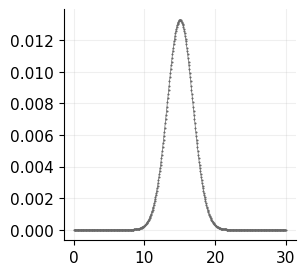

<Figure size 300x300 with 0 Axes>

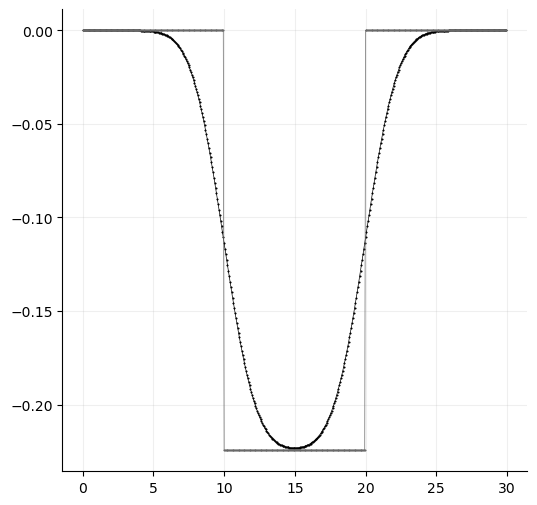

Potentials have the same 'area'
-37.48482000000006
-37.48481996724196


<Figure size 600x600 with 0 Axes>

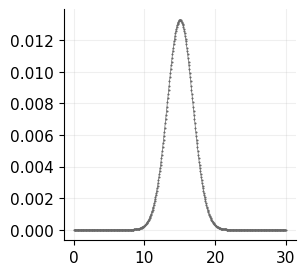

<Figure size 300x300 with 0 Axes>

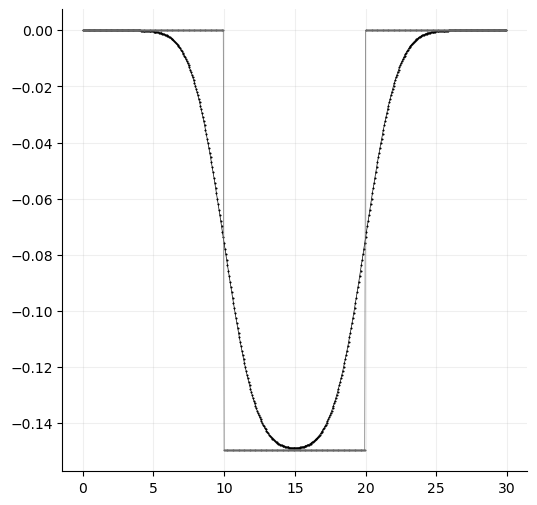

Potentials have the same 'area'
-24.989880000000078
-24.989879978161305


<Figure size 600x600 with 0 Axes>

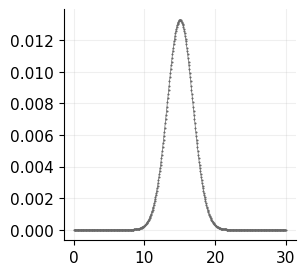

<Figure size 300x300 with 0 Axes>

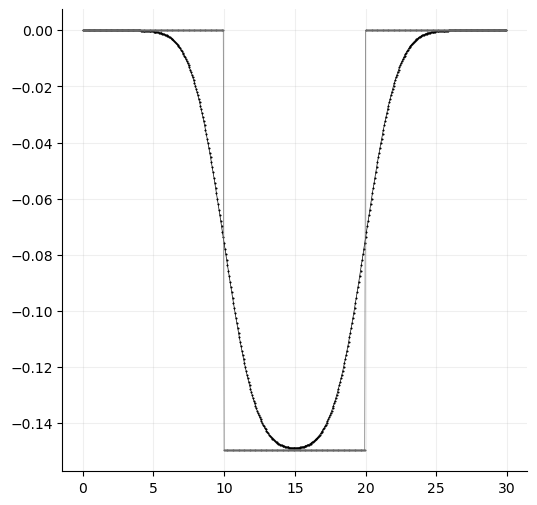

Potentials have the same 'area'
-24.989880000000078
-24.989879978161305


In [114]:
electric_field = 0

# Convolution of well potential with gaussian
pot_org = np.zeros(number_steps)
pot_QWI = np.zeros((3,number_steps))
func_x = np.zeros(number_steps)
Gauss_y = np.zeros(number_steps)
x_0 = number_steps / 2
sigma = 30
for p in range(3):
    for i in range(number_steps):
        pot_org[i] = QW.potential(p,x[i])
        func_x[i] = i
        Gauss_y[i] = 1.0/np.sqrt(np.sqrt(2*np.pi)*sigma)*np.exp(-(func_x[i]-x_0)*(func_x[i]-x_0)/(2.0*sigma*sigma))

    N_G = abs(sum(Gauss_y))
    Gauss_y = Gauss_y/N_G
    
    aspect_ratio=[3,3]
    plot_graph(x, Gauss_y)   

    pot_org_new = pad_func_zeros(pot_org)
    Gauss_y_new = pad_func_zeros(Gauss_y)
    x_new = pad_func_linear(x)

    LEGEND=False
    pot_QWI[p] = np.roll(convolve(pot_org_new, Gauss_y_new), int(number_steps))[int(number_steps*2/4):int(number_steps*2*3/4)]
    aspect_ratio=[5,5]
    plot_graphs(x, [pot_QWI[p], pot_org])    

    print("Potentials have the same 'area'")
    print(sum(pot_org))
    print(sum(pot_QWI[p]))

In [116]:
def solve(heterostructure): # Arbitrary, one operation, get all possible states/wavefunctions for a given structure
    Energies = np.zeros((3,number_steps))
    #eigenVector_ = [[0]*number_steps]*3
    eigenVector_ = [[0]*number_steps for _ in range(3)]
    potential_in_use = pot_QWI

    for p in range(0, 3): # solve for electron, heavy hole, and light hole
        M = np.zeros((number_steps, number_steps))
        x = np.zeros(number_steps)

        delta_x = heterostructure.heterostructure_thickness / (number_steps + 1.0)
        x[0] = delta_x

        alpha_w = np.zeros(number_steps)
        alpha_e = np.zeros(number_steps)
        alpha_x = np.zeros(number_steps)

        particle = ['e', 'lh', 'hh']

        alpha_w[0] = -(hbar*hbar/2.0) * 1.0/(delta_x*delta_x) * 2.0/(heterostructure.eff_mass(particle[p],x[0])+heterostructure.eff_mass(particle[p],x[0]))
        alpha_e[0] = -(hbar*hbar/2.0) * 1.0/(delta_x*delta_x) * 2.0/(heterostructure.eff_mass(particle[p],x[0])+heterostructure.eff_mass(particle[p],x[1]))
        alpha_x[0] = -alpha_w[0]-alpha_e[0]

        M[0][0] = alpha_x[0] + potential_in_use[p][0]
        M[0][1] = alpha_e[0]

        for nr in range(0, number_steps):
            x[nr] = x[0] + nr*delta_x

        for nr in range(1, number_steps-1): #range runs from 1 to num_steps-2 (stupid)
            alpha_w[nr] = -(hbar*hbar/2.0) * 1.0/(delta_x*delta_x) * 2.0/(heterostructure.eff_mass(particle[p],x[nr])+heterostructure.eff_mass(particle[p],x[nr-1]))
            alpha_e[nr] = -(hbar*hbar/2.0) * 1.0/(delta_x*delta_x) * 2.0/(heterostructure.eff_mass(particle[p],x[nr])+heterostructure.eff_mass(particle[p],x[nr+1]))
            alpha_x[nr] = -alpha_w[nr]-alpha_e[nr]

            M[nr][nr-1] = alpha_w[nr]    #sub-diagonal
            M[nr][nr] = alpha_x[nr] + potential_in_use[p][nr] #diagonal
            M[nr][nr+1] = alpha_e[nr]   #upper diagonal 

        alpha_w[number_steps-1] = -(hbar*hbar/2.0) * 1.0/(delta_x*delta_x) * 2.0/(heterostructure.eff_mass(particle[p],x[number_steps-1])+heterostructure.eff_mass(particle[p],x[number_steps-1-1]))
        alpha_e[number_steps-1] = -(hbar*hbar/2.0) * 1.0/(delta_x*delta_x) * 2.0/(heterostructure.eff_mass(particle[p],x[number_steps-1])+heterostructure.eff_mass(particle[p],x[number_steps-1])) # assuming m(x_edge-dx) = m(x_edge) as boundary condition
        alpha_x[number_steps-1] = -alpha_w[number_steps-1]-alpha_e[number_steps-1]
        M[number_steps-1][number_steps-2] = alpha_w[number_steps-1]
        M[number_steps-1][number_steps-1] = alpha_x[number_steps-1] + potential_in_use[p][number_steps-1]

        w,v=eig(M)

        idx = np.argsort(w) # sort in terms of energies
        w = w[idx]
        v = v[:,idx]
        
        for i in range(number_steps):
            #print(len(eigenVectors[0]))
            Energies[p][i] = w[i]
            eigenVector_[p][i] = v[:,i]
        
    return x, Energies, eigenVector_

def relative_energy(energy, p): # accept a 2 paramters [energy relative to well of..][particle type]
    # corrects an (inital) calculated energy from QW solution for respective band of type particle type p
    EF_offset = electron_charge*electric_field*QW.heterostructure_thickness
    BG = min(abs(layers[i].material.band_gap) for i in range (0, len(layers)-1)) # this should be okay with and without override on    
    if(p==0):
        if over_ride_offsets == True:
            E_REL = energy + BG + max(abs(CBO_override[i]) for i in range(0, len(layers)-1))
        else:
            E_REL = energy + BG + max(abs(CBO(layers[i].material, layers[i+1].material)) for i in range(0, len(layers)-1))
    else: #(p==1 or p==2):
        if over_ride_offsets == True:
            E_REL = -max(abs(VBO_override[i]) for i in range(0, len(layers)-1)) - energy + EF_offset
        else:
            E_REL = -max(abs(VBO(layers[i].material, layers[i+1].material)) for i in range(0, len(layers)-1)) - energy + EF_offset
    return E_REL

def find_transitions(energies): # accept a SORTED 2 Dimensional matrix [3][number_solutions] ... 
    E_gap = np.zeros((number_steps, number_steps, 2))
    for k in range(2): # for 2 hole types
        for i in range(len(energies[0])): # for all electrons
            for j in range(len(energies[0])): # and all hole states
                E_gap[i][j][k] = abs(energies[0][i]-energies[k+1][j])
    return E_gap # a matrix/array of energy transtions indexed as [electron state][hole state][hole type] 

def find_energies_relative(energies): # accept a 2 Dimensional matrix [3][number_solutions]
    energies_relative = np.zeros((3, number_steps))
    for k in range(3): # for 3 particle types
        for i in range(len(energies[0])): # for all states
            energies_relative[k][i] = relative_energy(energies[k][i], k)
    return energies_relative # returns [3][number_solutions] matrix of energies relative to their ectual value in well structure

def overlap_integral(vector1, vector2):    # S = <v_1|v_2> | accept only vectors of same length
    overlap = np.zeros(len(vector1))       # assuming both are the same length
    N1 = sum(abs(vector1)**2)              # Normalisation constant N = <v|v>
    N2 = sum(abs(vector2)**2)
    #print("N1 = {}".format(N1))
    #print("N2 = {}".format(N2))
    vector1_dummy = vector1 / N1           # normalise wavefunctions (N^-1)|v>
    vector2_dummy = vector2 / N2
    for i in range(len(vector1)):
        overlap[i] = (vector1_dummy[i]*vector2_dummy[i]) 
    return overlap                         # I = <v_1|v_2>

def I_squared(vector1, vector2):           # S = <v_1|v_2> | accept only vectors of same length
    overlap = overlap_integral(vector1, vector2)
    I_squared = sum(abs(overlap))**2
    return I_squared            # I^2 = |<v_1|v_2>|^2

def find_overlaps_all(wavefunctions): # accept matrix of size [particle type (0,1,2)][number_steps] directly from solve(QW)
    I_squared_matrix = np.zeros((number_steps, number_steps, 2)) # [electron state][hole state][hole type]
    for k in range(2): # for 2 hole types
        for i in range(len(wavefunctions[0])): # for all electrons
            state1 = wavefunctions[0][i]
            for j in range(len(wavefunctions[0])): # and all hole states
                state2 = wavefunctions[1+k][j] # [1+k] so that we index correct state - wavefunctions indexed as [particle type (0,1,2)][number_steps]
                I_squared_matrix[i][j][k] = I_squared(state1, state2)
    return I_squared_matrix # a matrix/array of wavefunction overlaps indexed as [electron state][hole state][hole type]

def convert_to_wavelength(E_GAP): # Gap between [electron state] and [hole state] of [hole type]
    E_GAP_WL = np.zeros((number_steps, number_steps, 2))
    for k in range(2): # for 2 hole types
        for i in range(number_steps): # for all electrons
            for j in range(number_steps): # and all hole states
                E_GAP_WL[i][j][k] = h_c / E_GAP[i][j][k]
    return E_GAP_WL

<Figure size 600x600 with 0 Axes>

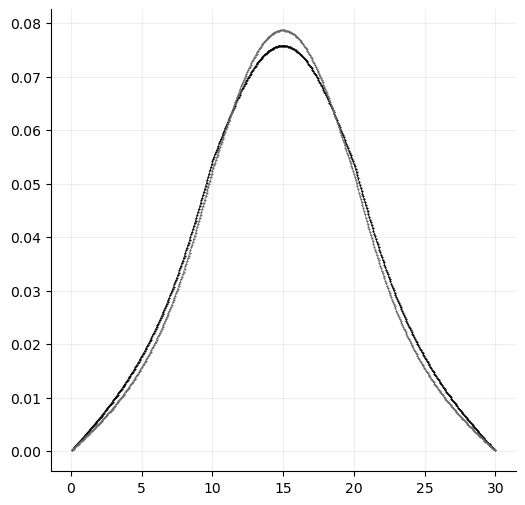

<Figure size 600x600 with 0 Axes>

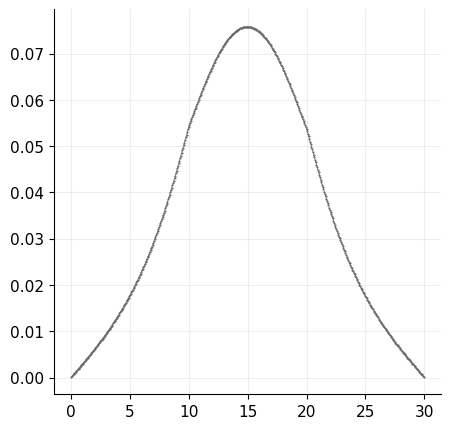

<Figure size 500x500 with 0 Axes>

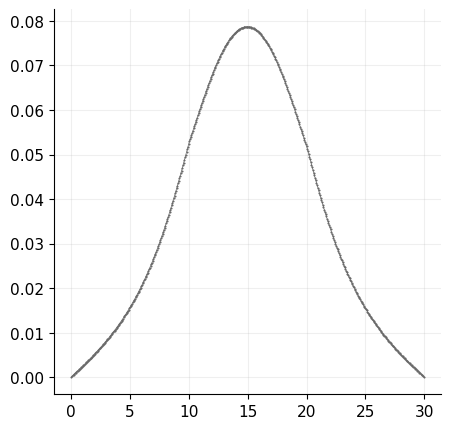

In [94]:
# RESULTS ------------------------------------------------------------------------------------

relative_energies = find_energies_relative(energies)
E_GAP = find_transitions(relative_energies)

PLOT_LIMIT=[]

plot_graphs(x, [wavefunctions[0][0], wavefunctions[1][0]])
plot_graph(x,wavefunctions[0][0])
plot_graph(x,wavefunctions[1][0])

In [93]:
# DEFINE STRUCTURE ---------------------------------------------------------------------------
layer1 = Layer(AlGaAs, 10) # 10nm thick layer of GaAs
layer2 = Layer(GaAs, 10) # 10nm thick layer of AlGaAs
layers = [layer1, layer2, layer1]
QW = Heterostructure(layers)

# OVERRIDE BAND OFFSETS | Done by hand : Array lengths must be num.layers-1 ------------------
electric_field = 0.01
over_ride_offsets = True
E_gap_diff = np.abs(-layer2.material.band_gap + layer1.material.band_gap)
conduction_band_offset_ratio = 0.6
valence_band_offset_ratio = 0.4
print(E_gap_diff)

# VBO_override = [-layer2.material.band_gap*valence_band_offset_ratio, layer2.material.band_gap*valence_band_offset_ratio]
# CBO_override = [-layer2.material.band_gap*conduction_band_offset_ratio, layer2.material.band_gap*conduction_band_offset_ratio]

VBO_override = [-E_gap_diff*valence_band_offset_ratio, E_gap_diff*valence_band_offset_ratio]
CBO_override = [-E_gap_diff*conduction_band_offset_ratio, E_gap_diff*conduction_band_offset_ratio]
print(VBO_override)
print(CBO_override)
# SOLVE --------------------------------------------------------------------------------------
x, energies, wavefunctions = solve(QW) # returns 2D matrices, index [particle type][solution in order from lowest]

0.3741000000000001
[-0.14964000000000005, 0.14964000000000005]
[-0.22446000000000005, 0.22446000000000005]


In [95]:
# For each pair the overlap integral of the wavefunction should be calculated.
# This provides the strength of the oscillator, or the absorption.

# This operation takes time.

M_I_squared = find_overlaps_all(wavefunctions)

In [96]:
# x axis, band gap, y elements all zero except if bandgap level has a corresponding absorption
# WAVELENGTH VERSION

E_MAX = 2
num_discrete = 2048 # Base 2 for FFT

WL_range = [600, 1100]

WL_xaxis = np.zeros(num_discrete)
absorption_yaxis = np.zeros(num_discrete)
delta_WL = (WL_range[1]-WL_range[0]) / (num_discrete-1)
epsilon = delta_WL*0.5

count = 0
for i in range(num_discrete):
    WL_xaxis[i] = WL_range[0]+i*delta_WL
    target_value = WL_xaxis[i]
    closest_value = np.unravel_index(np.argmin(np.abs(E_GAP_WL - target_value), axis=None), E_GAP_WL.shape)
    prox_check = E_GAP_WL[closest_value[0]][closest_value[1]][closest_value[2]]
    if(prox_check < target_value+epsilon and prox_check > target_value-epsilon):
        absorption_yaxis[i] = M_I_squared[closest_value[0]][closest_value[1]][closest_value[2]]
        count += 1
        
plot_graph(WL_xaxis, absorption_yaxis)

print(count)
print(closest_value)
print(E_GAP_WL[closest_value[0]][closest_value[1]][closest_value[2]])
print(M_I_squared[closest_value[0]][closest_value[1]][closest_value[2]])

NameError: name 'E_GAP_WL' is not defined

In [ ]:
# voigt function details
num_discrete = 2048
func_x = np.zeros(num_discrete)
Gauss_y = np.zeros(num_discrete)
Lorentz_y = np.zeros(num_discrete)
x_0 = num_discrete/2
gamma = 50
sigma = gamma
PLOT_LIMIT=[]

def pad_func_zeros(func):
    func_new = np.zeros(2*len(func))
    j = 0
    for i in range(int(0.25*len(func_new)), int(0.75*len(func_new))):
        func_new[i] = func[j]
        j+=1
    return func_new # twice in length

def pad_func_linear(func):
    func_new = np.zeros(2*len(func))
    j = 0
    del_f = np.abs(func[1]-func[2])
    for i in range(0, int(0.25*len(func_new))):
        func_new[i] = func[0]-0.5*(func[len(func)-1]-func[0]) + i*del_f
    for i in range(int(0.25*len(func_new)), int(0.75*len(func_new))):
        func_new[i] = func[j]
        j+=1
    w=j-1
    j=1
    for i in range(int(0.75*len(func_new)), len(func_new)):
        func_new[i] = func[w] + j*del_f
        j+=1
    return func_new # twice in length

def pad_E(f):
    del_f = np.max(f)/(num_discrete-1)
    func_new = np.zeros(2*len(f))
    j = 0
    for i in range(len(func_new)):
        func_new[i] = del_f*i
    return func_new # twice in length

def convolve(f, g): # PAD ARRAYS BEFORE USE FRO ABSORPTION
    FFT_f = np.fft.fft(f)
    FFT_g = np.fft.fft(g)
    FG = FFT_f * FFT_g
    result = np.fft.ifft(FG)
    return np.real(result)

for i in range(num_discrete):
    func_x[i] = i
    Gauss_y[i] = 1.0/np.sqrt(np.sqrt(2*np.pi)*sigma)*np.exp(-(func_x[i]-x_0)*(func_x[i]-x_0)/(2.0*sigma*sigma))
    Lorentz_y[i] = 1.0/np.pi * 0.5*gamma/((func_x[i]-x_0)**2 + (0.5*gamma)**2)

plot_graph(func_x,Gauss_y)
plot_graph(func_x,Lorentz_y)

func_x_new = pad_func_linear(func_x)
WL_axis_new = pad_func_linear(WL_xaxis)
absorption_yaxis_new = pad_func_zeros(absorption_yaxis)
Lorentz_y_new = pad_func_zeros(Lorentz_y)
#plot_graph(func_x_new, E_axis_new)
Gauss_y_new = pad_func_zeros(Gauss_y) 
plot_graph(func_x_new, absorption_yaxis_new)

voigt_y = convolve(Lorentz_y_new, Gauss_y_new)
plot_graph(WL_axis_new, voigt_y)
absorption = convolve(absorption_yaxis_new, voigt_y)
plot_graph(WL_axis_new, absorption)
print(len(voigt_y))

In [ ]:
# Do it for multiple electric fields

num_discrete = 2048 # Base 2 for FFT
func_x = np.zeros(num_discrete)
Gauss_y = np.zeros(num_discrete)
Lorentz_y = np.zeros(num_discrete)
x_0 = num_discrete/2

gamma = 50
PLOT_LIMIT=WL_range
delta_WL = (WL_range[1]-WL_range[0]) / (num_discrete-1)
epsilon = delta_WL*0.5
sigma = gamma

data = []
legend = []

for i in range(num_discrete):
    func_x[i] = i
    Gauss_y[i] = 1.0/np.sqrt(np.sqrt(2*np.pi)*sigma)*np.exp(-(func_x[i]-x_0)*(func_x[i]-x_0)/(2.0*sigma*sigma))
    Lorentz_y[i] = 1.0/np.pi * 0.5*gamma/((func_x[i]-x_0)**2 + (0.5*gamma)**2)

func_x_new = pad_func_linear(func_x)
WL_axis_new = pad_func_linear(WL_xaxis)
#absorption_yaxis_new = pad_func_zeros(absorption_yaxis)
Lorentz_y_new = pad_func_zeros(Lorentz_y)
#plot_graph(func_x_new, E_axis_new)
Gauss_y_new = pad_func_zeros(Gauss_y)
#plot_graph(func_x_new, absorption_yaxis_new)

voigt_y = convolve(Lorentz_y_new, Gauss_y_new)

number_runs = 11
delta_field = 0.0025
print("Starting..")
j=0
for i in range(number_runs):
    electric_field = i*delta_field
    x, energies, wavefunctions = solve(QW) # returns 2D matrices, index [particle type][solution in order from lowest]
    relative_energies = find_energies_relative(energies)
    E_GAP = find_transitions(relative_energies)
    E_GAP_WL = convert_to_wavelength(E_GAP)
    M_I_squared = find_overlaps_all(wavefunctions)

    WL_xaxis = np.zeros(num_discrete)
    absorption_yaxis = np.zeros(num_discrete)

#   epsilon = delta_E*0.5
    count = 0
    for i in range(num_discrete):
        WL_xaxis[i] = WL_range[0]+i*delta_WL
        target_value = WL_xaxis[i]
        closest_value = np.unravel_index(np.argmin(np.abs(E_GAP_WL - target_value), axis=None), E_GAP_WL.shape)
        prox_check = E_GAP_WL[closest_value[0]][closest_value[1]][closest_value[2]]
        if(prox_check < target_value+epsilon and prox_check > target_value-epsilon):
            absorption_yaxis[i] = M_I_squared[closest_value[0]][closest_value[1]][closest_value[2]]
            count += 1
    absorption_yaxis_new = pad_func_zeros(absorption_yaxis)     
    absorption = convolve(absorption_yaxis_new,voigt_y)
    data.append(absorption)
    clear_output(wait=True)
    legend.append(str(electric_field) + "V/nm")
    print(str(j+1) + " of {} runs complete.".format(number_runs))
    j+=1

plot_graphs(WL_axis_new, data)